### List of what you need to do:
- ~~Define the Queue (generic)~~
- ~~Define the Q-Table (just empty table with all possible states)~~
- Start Q-Learning Loop

In [79]:
# All Imports and Constants
import sys
!{sys.executable} -m pip install gym
import numpy as np
import gym
from gym import spaces
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 5000
EPISODE_GRAPH_INTERVAL = EPISODES // 10

# parameters for epsilon decay policy
EPSILON = 1.0 # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2
epsilon_decay_value = EPSILON / (END_EPSILON_DECAYING - START_EPSILON_DECAYING) # 1 / (250 - 1) = 1 / 249

# for testing
N_TEST_RUNS = 100
TEST_INTERVAL = 500

MAX_TIMESLOTS = 100
MAX_WAIT_STATE = 50 #used as upper limit in q-table

# Generic Queue Simulator
We want to define a generic queue simulator that has its own arrival rates/mean delay requirements so that we can use it for PQ1, PQ2 and Best-Effort, as well as the other queues such as FIFO, RR, etc.

In [80]:
class QueueSimulator(gym.Env):
    def __init__(self, arrival_rates, mean_delay_requirements, queues_finished_timeslots):
        super(QueueSimulator, self).__init__()
        self.arrival_rates = arrival_rates
        self.mean_delay_requirements = mean_delay_requirements
        self.current_timeslot = 1
        self.queues_finished_timeslots = queues_finished_timeslots # Need some reference to this so that I can use it again after reset
        self.queues = copy.deepcopy(queues_finished_timeslots)
        
        # Graph the total wait times for each queue, and at certain episode intervals, add the wait times to the map
        self.queues_total_wait_times = [[], [], []]
        self.queues_total_wait_times_map = {}
        
        # Action Space is 3, because we have 3 queues to choose from
        self.action_space = spaces.Discrete(3)
        
        # We know the observation space are the range of possible and observable values. This is wait times,
        # so wait times can be 0 or infinity technically.
        self.observation_space = spaces.Box(low=np.array([0, 0, 0]), high=np.array([np.inf, np.inf, np.inf]), dtype=np.dtype(int))
   
    # Get current wait times for each queue (so how long a queue has been waiting for on a packet to send)
    def calc_state(self):
        calc_state = [0, 0, 0]
        
        for i, queue in enumerate(self.queues):
            queue_total_wait = 0
            for packet in queue:
                if packet <= self.current_timeslot:
                    queue_total_wait += (self.current_timeslot - packet)
            calc_state[i] = queue_total_wait
        return calc_state

    # Every step means you calc state_new, reward, done and info
    # Reward should be based on wait time for a packet, as in give HIGHEST reward when 
    #     queue has had to wait for its entire mean_delay_requirement duration
    def step(self, action):
        # First, check how long each queue has been waiting for (this is the initial state)
        current_state = self.calc_state()
        
        # Now calc reward
        # If the wait time for [action] queue is 0, then we DO NOT WANT TO reward the model. Even if all queues have 0 wait time, we shouldnt reward it for a 'default' choice
        if current_state[action] == 0:
            reward = 0
        else:
            reward = (100 / self.mean_delay_requirements[action]) * (current_state[action])
            
        # Reward when the best effort queue is chosen should be really high, but not as high as when mean_delay_requirement is met (100 reward)
        if action == 2:
            reward = 99
        
        # Everytime you transmit a packet, keep track of how long that packet had to wait in queues_total_wait_times to graph later
        # also, only delete if that packet actually exists in the queue (i.e. its arrived, which is only at a certain timeslot onwards)
        if (len(self.queues[action]) > 0 and self.queues[action][0] <= self.current_timeslot):
            self.queues_total_wait_times[action].append(current_state[action])
            del self.queues[action][0]
        
        # Now get new state to send back
        new_state = self.calc_state()
        
        done = False
        if all(len(queue) == 0 for queue in self.queues):
            done = True

        self.current_timeslot += 1
        return new_state, reward, done, {}
        
    # Since q_learning expects state reset too, return the calc_state method
    # Also, take episode number here cuz i want to graph the wait_times after X episode intervals
    def reset(self, episode):
        if episode % EPISODE_GRAPH_INTERVAL == 0:
            self.queues_total_wait_times_map.update( {episode: self.queues_total_wait_times} )
        self.current_timeslot = 0
        self.queues = copy.deepcopy(self.queues_finished_timeslots)
        self.queues_total_wait_times = [[], [], []]
        return self.calc_state()
        
    def render(self):
        return self


# Pre-populating Queues
If given the arrival_rates and mean_delay_requirements, you could calculate what timeslots a packet will arrive for any number of timeslots. Hence, we believe that you should just 'pre-populate' your queues with the times that packets arrive at, since this simplifies all of the packet arrival/transmission, and you can later use this to measure wait times and give this information to your model to determine an action to take every step of the way.

In [81]:
# Create the basic env and put logic for the actions
arrival_rates = [0.3, 0.25, 0.4]
mean_delay_requirements = [6, 4, np.inf]
# Keep track of current packets by using another array, which has index corresponding to the arrival_rates
queues_packet_status = [0, 0, 0]
# See all timeslots where a queue finished transmitting a packet
queues_finished_timeslots = [[], [], []]

# At each time interval, increment each queue's current packet status by the arrival rate amount
# if packet status >= 1, get the extra amt above 1 and change packet status to just that
for timeslot in range(1, MAX_TIMESLOTS+1):
    for current_queue in range (len(arrival_rates)):
        queues_packet_status[current_queue] += arrival_rates[current_queue]
        
        if queues_packet_status[current_queue] >= 1.0:
            queues_finished_timeslots[current_queue].append(timeslot)
            queues_packet_status[current_queue] -= 1.0

# Result of queues_finished_timeslots
print('{0} -> Length = {1}'.format(queues_finished_timeslots[0], len(queues_finished_timeslots[0])))
print('{0} -> Length = {1}'.format(queues_finished_timeslots[1], len(queues_finished_timeslots[1])))
print('{0} -> Length = {1}'.format(queues_finished_timeslots[2], len(queues_finished_timeslots[2])))


[4, 7, 11, 14, 17, 21, 24, 27, 31, 34, 37, 41, 44, 47, 51, 54, 57, 61, 64, 67, 71, 74, 77, 81, 84, 87, 91, 94, 97] -> Length = 29
[4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100] -> Length = 25
[3, 5, 8, 10, 13, 15, 18, 20, 23, 25, 28, 30, 33, 35, 38, 40, 43, 45, 48, 50, 53, 55, 58, 60, 63, 65, 68, 70, 73, 75, 78, 80, 83, 85, 88, 90, 93, 95, 98, 100] -> Length = 40


'queues_finished_timeslots' is essentially our environment. We want to take this environment and apply it to a Q-Table, where the Q-Table represents all possible states (states being how long a queue has waited), then some reward for an action given a specific state. Below is what the Q-Table could look like, with a state e.g. (1, 0, 3) saying that the first packet in queue 1 has waited 1 timeslots, queue 2 has waited 0 timeslots, and queue 3 has waited 3 timeslots.

|                       | 0           | 1           | 2           |
|-----------------------|:-----------:|-------------|-------------|
| State (0, 0, 0)       | some-reward | some-reward | some-reward |
| State (0, 0, 1)       | some-reward | some-reward | some-reward |
| State (0, 1, 1)       | "         " | "         " | "         " |
| State (  ...  )       |             |             |             |
| State (Inf, Inf, Inf) | some-reward | some-reward | some-reward |

# Setting Up Q-Learning
First, we need to make a Q-Table with empty values. Access to an entry is given with the state (x, y, z).
Also, the upper state cannot be infinity so we can choose an arbitrary value (but still one that is somewhat realistic).

In [82]:
def create_q_table():
    q_table = {}
    for q1 in range (MAX_WAIT_STATE+1):
        for q2 in range (MAX_WAIT_STATE+1):
            for q3 in range (MAX_WAIT_STATE+1):
                q_table[q1, q2, q3] = np.zeros(3)
    return q_table

# Start Q-Learning Loop
1. For every episode, do another 'until done' loop
2. While not done:
    - Get a random chance, and either get value from Q-Table (exploit) or do random action (explore)
    - Do next step() for env
    - Update Q-Table and any other variables
3. Update epsilon
4. Can do some update per episode, but if we're doing minimum 500 episodes more likely to do some performance check every X interval e.g. every 50 episodes get some check in.

In [83]:
def max_limit_state(state):
    for i, wait_time in enumerate(state):
        if wait_time > MAX_WAIT_STATE:
            state[i] = MAX_WAIT_STATE
    return state

def q_learning(env, q_table):
    for episode in range(1,EPISODES+1):
        done = False
        state = env.reset(episode)
        epsilon = EPSILON
        steps = 0

        # Either do action from QTable or random action
        while not done:
            if np.random.random() < 1 - epsilon:
                action = np.argmax(q_table[state])
            else:
                action = env.action_space.sample()
                
            # Get the next state, reward, new done value, and info (not sure what this is)
            # Also, in early episodes the queues can wait for very long times. Put a limit on the wait times in new_state
            new_state, reward, done, info = env.step(action)
            new_state = max_limit_state(new_state)

            # Update QTable and calc reward. Not sure why current_q in example is 'discretState+(action,)'
            # Note: Need to convert new_state to tuple since q_table entries are as tuples
            q_table_key = tuple(new_state)
            new_max_q = np.max(q_table[q_table_key])
            current_q = q_table[q_table_key][action]
            q_table[q_table_key][action] = (1 - LEARNING_RATE)*current_q + LEARNING_RATE*(reward + DISCOUNT*new_max_q)

            state = new_state
            steps += 1

        # Finished done loop, update epsilon
        if END_EPSILON_DECAYING >= episode and episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value

        # Print progress every X episodes
        if episode % TEST_INTERVAL == 0 and episode != 0:
            print('Finished {0} episodes'.format(episode))

    print('Finished all episodes')
    env.close()
    return q_table

env = QueueSimulator(arrival_rates, mean_delay_requirements, queues_finished_timeslots)
q_table = create_q_table()
result_q_table = q_learning(env, q_table)

Finished 500 episodes
Finished 1000 episodes
Finished 1500 episodes
Finished 2000 episodes
Finished 2500 episodes
Finished 3000 episodes
Finished 3500 episodes
Finished 4000 episodes
Finished 4500 episodes
Finished 5000 episodes
Finished all episodes


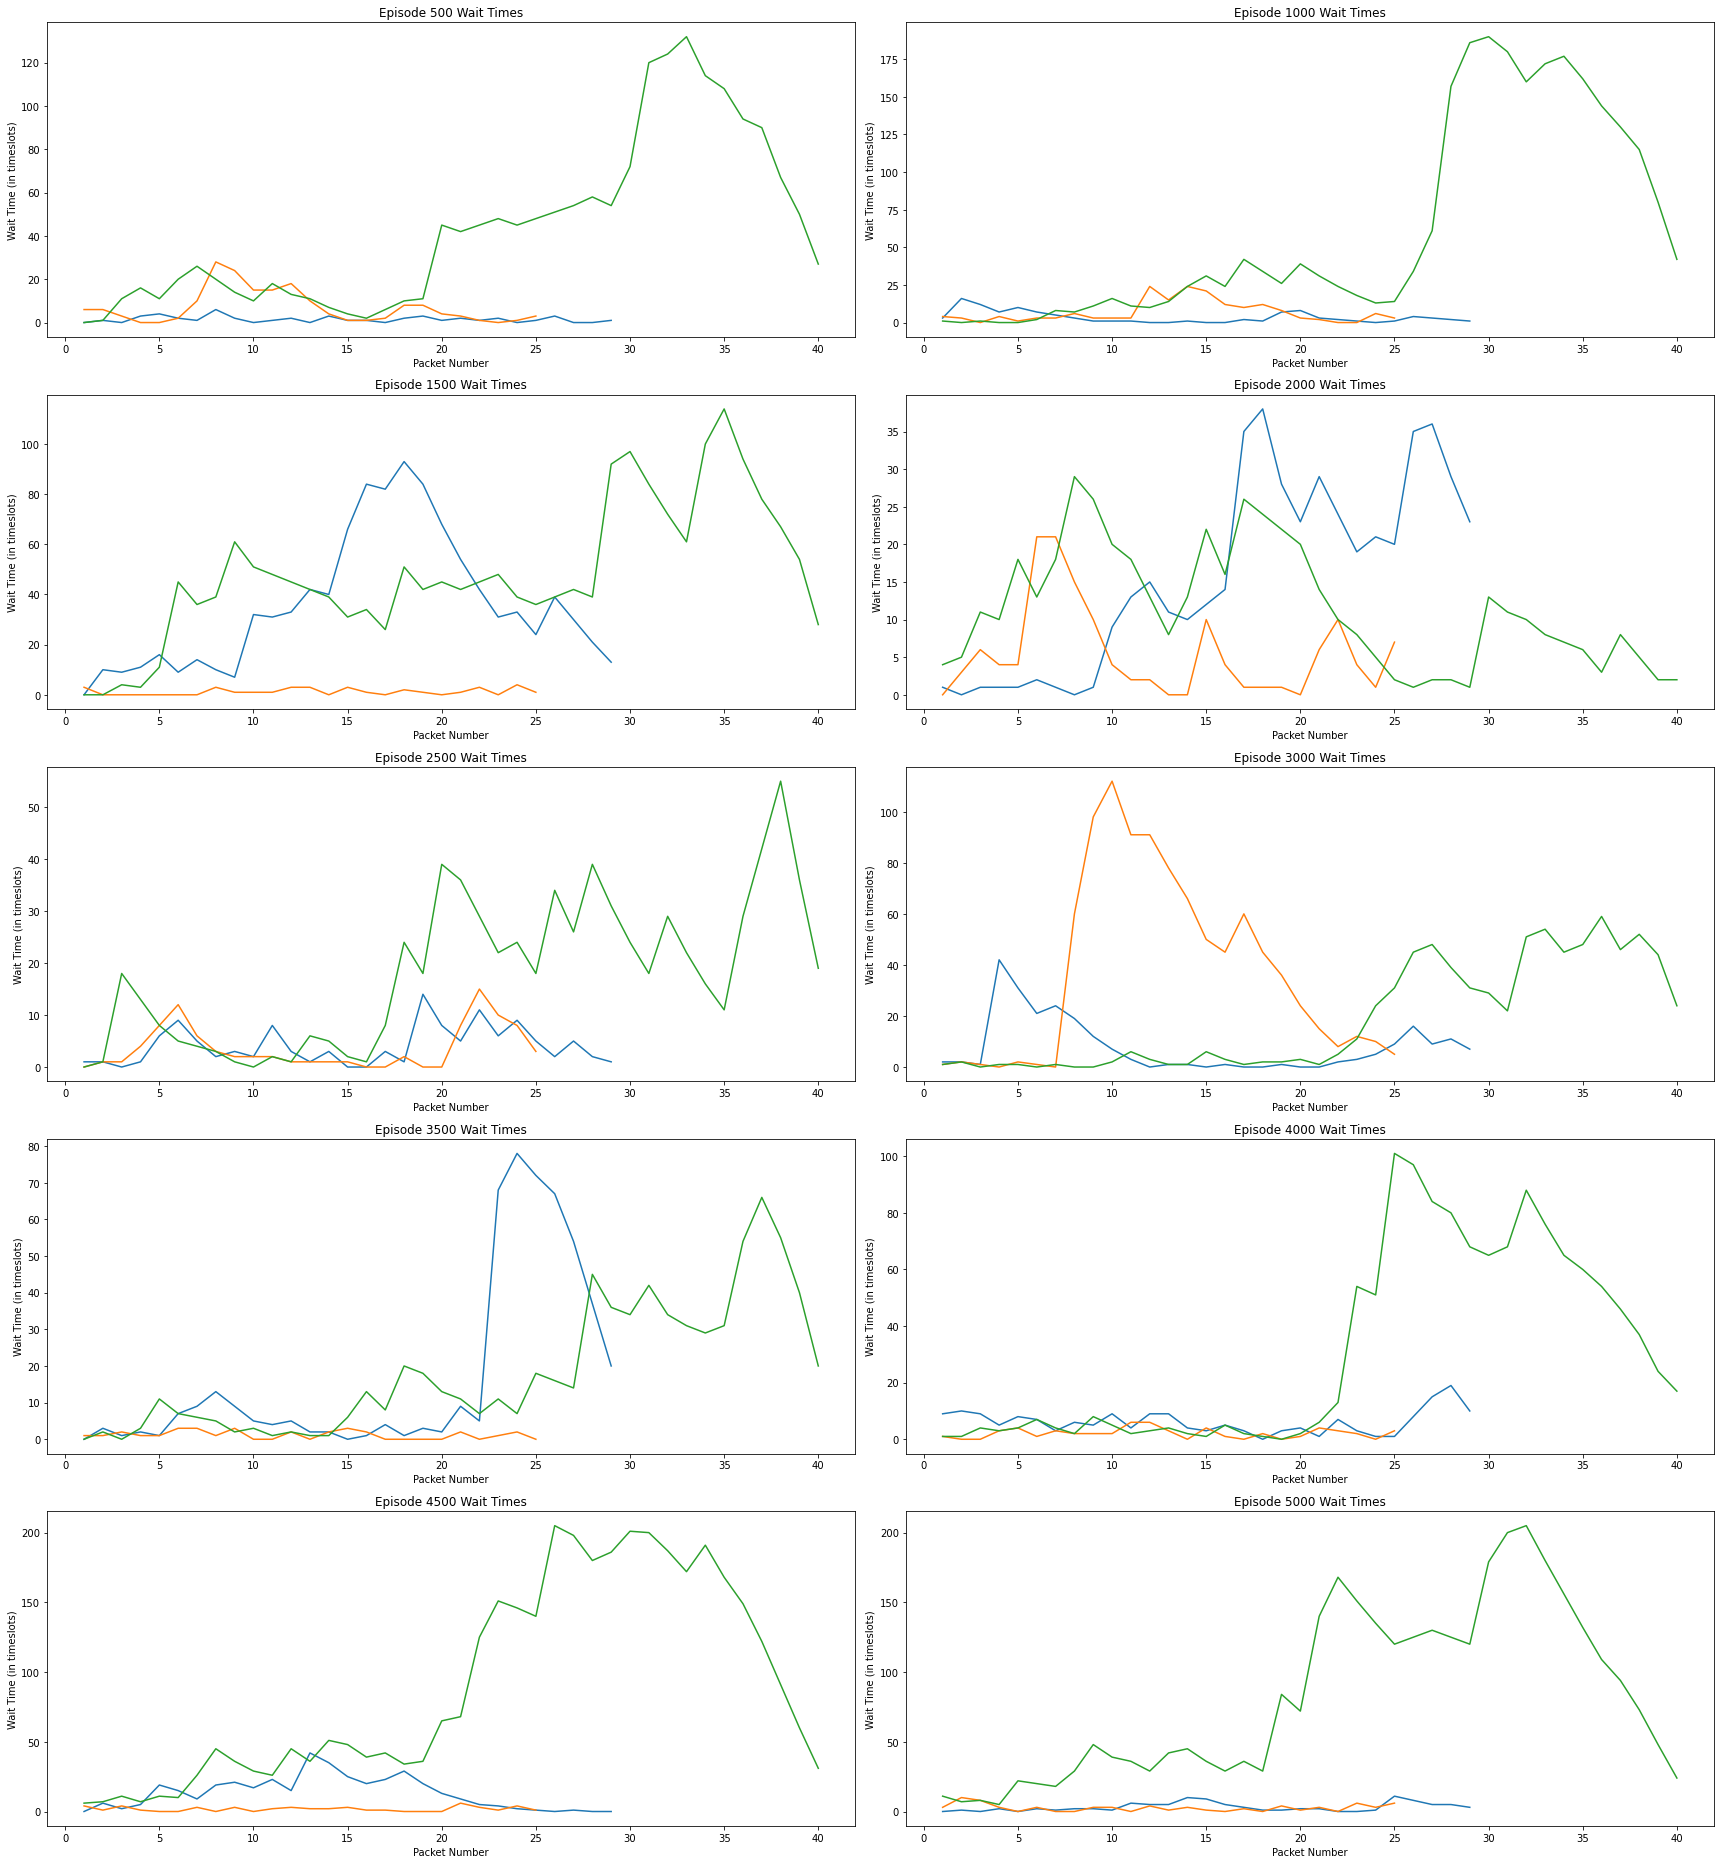

In [84]:
# for i, queue_wait_times in enumerate(env.queues_total_wait_times):
#     data_x = [*range(1, len(queue_wait_times)+1, 1)]
#     data_y = queue_wait_times
    
#     figure(figsize=(12,4))
#     plt.title('Queue {0} Wait Times'.format(i+1))
#     plt.xlabel('Packet Number')
#     plt.ylabel('Wait Time (in timeslots)')
#     plt.scatter(data_x, data_y)
#     plt.plot(data_x, data_y)
#     plt.show()
#     print('Queue {0} Wait Times List: {1}'.format(i+1, queue_wait_times))

row = 0
col = 0
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(24, 26))
for episode in env.queues_total_wait_times_map:
    ax = axes[row][col]
    q1_ep_y = env.queues_total_wait_times_map.get(episode)[0]
    q2_ep_y = env.queues_total_wait_times_map.get(episode)[1]
    q3_ep_y = env.queues_total_wait_times_map.get(episode)[2]
    q1_ep_x = [*range(1, len(q1_ep_y)+1, 1)]
    q2_ep_x = [*range(1, len(q2_ep_y)+1, 1)]
    q3_ep_x = [*range(1, len(q3_ep_y)+1, 1)]

    ax.set_title('Episode {0} Wait Times'.format(episode))
    ax.set_xlabel('Packet Number')
    ax.set_ylabel('Wait Time (in timeslots)')
    ax.plot(q1_ep_x, q1_ep_y)
    ax.plot(q2_ep_x, q2_ep_y)
    ax.plot(q3_ep_x, q3_ep_y)
    col += 1
    
    if col == 2:
        row += 1
        col = 0
fig.tight_layout()


In [85]:
## Things to vary: episodes, amount of packets (i.e. timeslots?), epsilon decay formula, reward somehow

# First-In-First-Out
Implementation is straight forward, transmit packets who arrive first. QueueSimulator can be used here but with logic to decide 'action' instead of epsilon/randomness

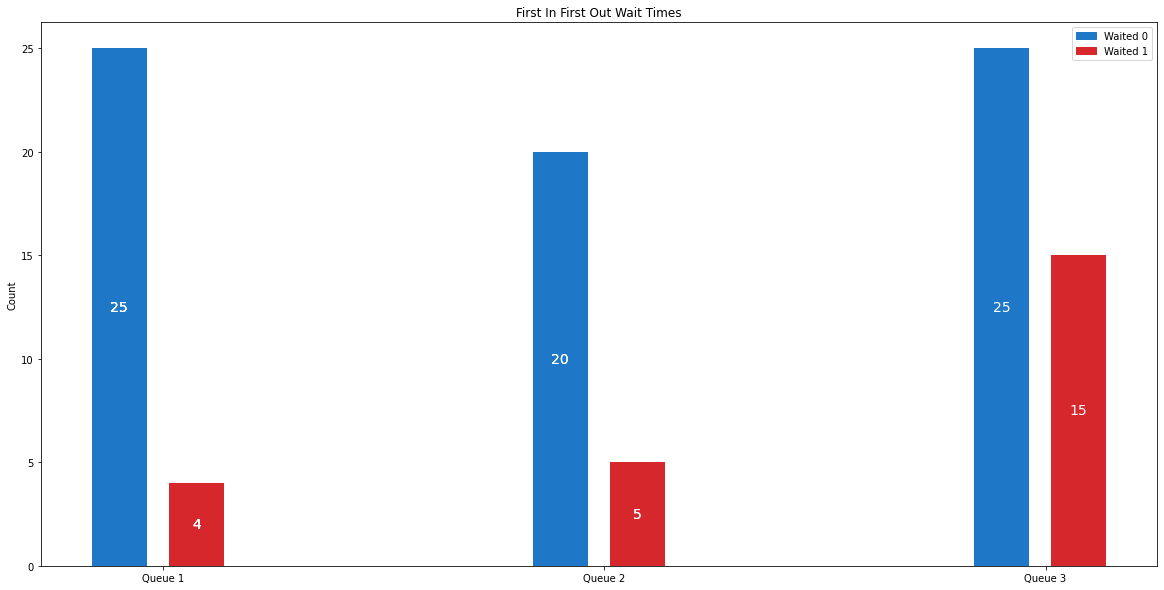

In [134]:
def first_in_first_out(env):
    env.reset(1)
    done = False
    
    while not done:
        # Our action is based on lowest value and if theres no packets left in a queue then its a '0' which is lowest possible. Hence, Set initial values to maximum
        current_state = [np.inf, np.inf, np.inf]
        for i, queue in enumerate(env.queues):
            # Check that first element of queue has actually arrived
            if len(queue) > 0 and env.current_timeslot >= queue[0]:
                current_state[i] = queue[0]
        
        # Action should be the packet that arrived first (i.e. lowest value)
        action = current_state.index(min(current_state))
        _, _, done, _ = env.step(action)
    
    return env.queues_total_wait_times

fifo_wait_times = first_in_first_out(env)

# Since the wait times were either 0 or 1, can just plot a hist or bar chart with x labels 0 or 1
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.25
for i, queue_wait_times in enumerate(fifo_wait_times):
    waited_0 = sum(1 for wait_time in queue_wait_times if wait_time == 0)
    waited_1 = sum(1 for wait_time in queue_wait_times if wait_time == 1)

    ax.bar(i*2, waited_0, bar_width, label='Waited 0', color='#1F77C7')
    ax.bar((i*2)+bar_width+0.1, waited_1, bar_width, label='Waited 1', color='#D6272C')
    ax.set_title('First In First Out Wait Times')
    ax.set_xticks((0.2, 2.2, 4.2))
    ax.set_xticklabels(("Queue 1", "Queue 2", "Queue 3"))
    ax.set_ylabel('Count')
    ax.legend(handles=[mpatches.Patch(color='#1F77C7', label='Waited 0'), mpatches.Patch(color='#D6272C', label='Waited 1')])
    
    for rect in ax.patches:
        h = rect.get_height()
        w = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        label_text = f'{h}'
        label_x = x + w/2
        label_y = y + h/2
        
        if h != 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=14, color='white')


# Earliest Deadline First
Bit more complicated than FIFO, because we need to consider difference in waiting and mean_delay_requirement, but also what to do with the best effort queue which has no mean delay requirement.
If the wait time for the best effort queue is less than the difference of (waiting and mean delay requirement) for the other two queues, prioritise best effort queue

[7, 6, 7, 9, 6, 7, 7, 6, 7, 9, 6, 7, 7, 6, 7, 9, 6, 7, 7, 6, 7, 9, 6, 7, 7, 6, 7, 9, 5]
[2, 3, 2, 3, 4, 3, 3, 2, 3, 4, 3, 3, 2, 3, 4, 3, 3, 2, 3, 4, 3, 3, 2, 3, 3]
[1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1]
291


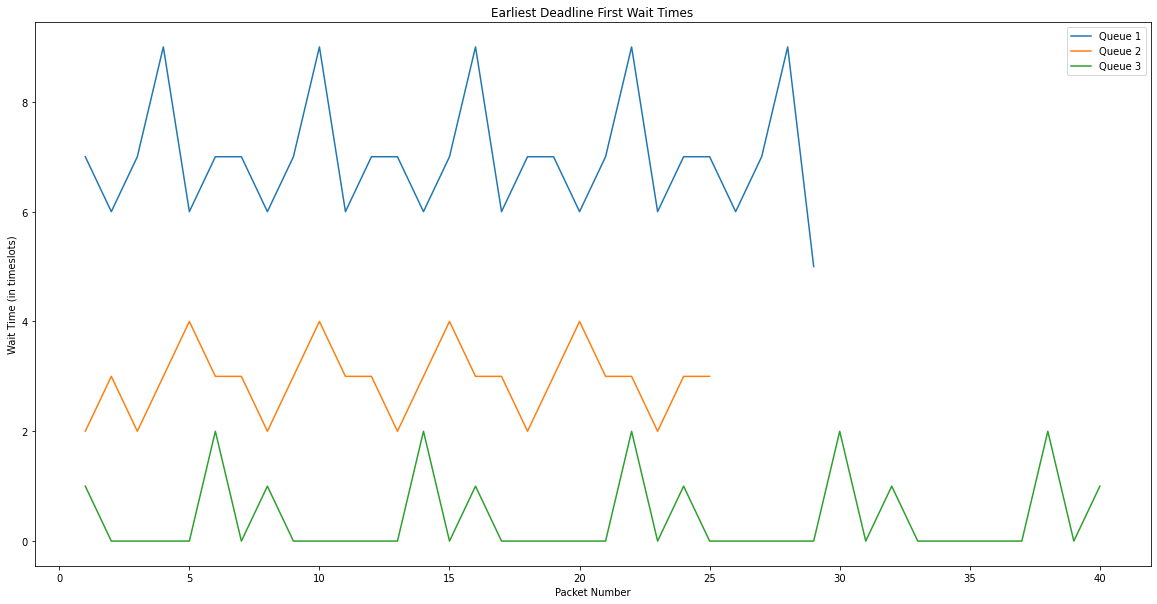

In [113]:
def earliest_deadline_first(env):
    env.reset(1)
    done = False
    
    while not done:
        # Use np.inf as an indicator that a packet hasn't arrived. So, you consider to transmit a queue only if there exists a packet in that queue. Will always default (through else statements) to queue 2.
        current_state = [np.inf, np.inf, np.inf]
        for i, queue in enumerate(env.queues):
            if len(queue) > 0 and env.current_timeslot >= queue[0]:
                current_state[i] = env.current_timeslot - queue[0]
                
        q1_diff = mean_delay_requirements[0] - current_state[0]
        q2_diff = mean_delay_requirements[1] - current_state[1]
        q3_wait = current_state[2]
            
        if (q3_wait < q1_diff and q3_wait < q2_diff and q3_wait != np.inf):
            action = 2
        else:
            if q1_diff < q2_diff and q1_diff != -np.inf:
                action = 0
            else:
                action = 1

        current_state, reward, done, info = env.step(action)
    return env.queues_total_wait_times

edf_wait_times = earliest_deadline_first(env)
for i, queue in enumerate(edf):
    print(queue)

fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.25
for i, queue_wait_times in enumerate(edf_wait_times):
    data_y = queue_wait_times
    data_x = [*range(1, len(data_y)+1, 1)]

    ax.set_title('Earliest Deadline First Wait Times')
    ax.set_xlabel('Packet Number')
    ax.set_ylabel('Wait Time (in timeslots)')
    ax.plot(data_x, data_y, label='Queue {0}'.format(i+1))
ax.legend()
fig.show()

# Sequential Priority Policy
With SPP, I believe that when the specifications say 'select a packet from the _highest priority queue_', the highest priority queue is whatever queue we believe it to be (i.e. its up to us to decide which queue is the most important). Best Effort Queue is always chosen to minimise the mean delay, so I think that the choice is either Priority Queue 1 or Priority Queue 2. As PQ2 has a lower mean delay requirement, it must output quicker and hence should be prioritised higher vs PQ1 which is given a longer time before it is needed to transmit.

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1]


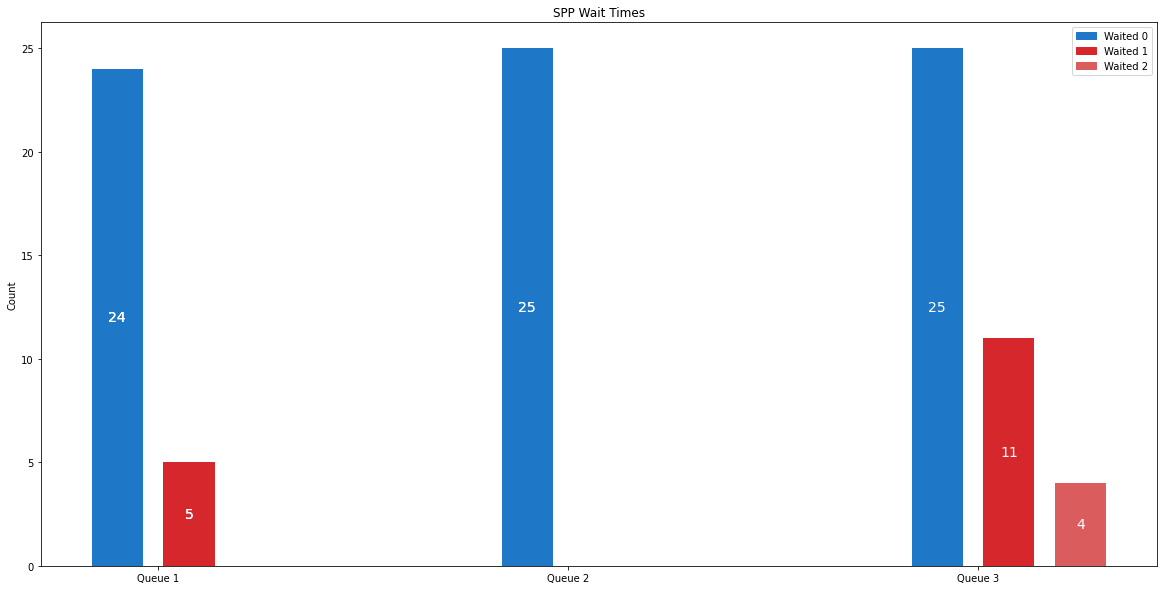

In [133]:
def sequential_priority_policy(env):
    current_state = env.reset(1)
    done = False
    
    while not done:
        # Use np.inf as an indicator that a packet hasn't arrived. So, you consider to transmit a queue only if there exists a packet in that queue. Will always default (through else statements) to queue 2.
        current_state = [np.inf, np.inf, np.inf]
        for i, queue in enumerate(env.queues):
            if len(queue) > 0 and env.current_timeslot >= queue[0]:
                current_state[i] = queue[0]
                
        action = 1
        if current_state[action] == np.inf:
            action = 0
            if current_state[action] == np.inf:
                action = 2
        
        new_state, reward, done, info = env.step(action)
    return env.queues_total_wait_times

spp_wait_times = sequential_priority_policy(env)
for i, q in enumerate(spp_wait_times):
    print(q)
    
# Since the wait times were either 0 or 1, can just plot a hist or bar chart with x labels 0 or 1
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.25
for i, queue_wait_times in enumerate(spp_wait_times):
    waited_0 = sum(1 for wait_time in queue_wait_times if wait_time == 0)
    waited_1 = sum(1 for wait_time in queue_wait_times if wait_time == 1)
    waited_2 = sum(1 for wait_time in queue_wait_times if wait_time == 2)

    ax.bar(i*2, waited_0, bar_width, label='Waited 0', color='#1F77C7')
    ax.bar((i*2)+bar_width+0.1, waited_1, bar_width, label='Waited 1', color='#D6272C')
    ax.bar((i*2)+(bar_width*2)+0.2, waited_2, bar_width, label='Waited 2', color='#DB5C5C')
    ax.set_title('SPP Wait Times')
    ax.set_xticks((0.2, 2.2, 4.2))
    ax.set_xticklabels(("Queue 1", "Queue 2", "Queue 3"))
    ax.set_ylabel('Count')
    ax.legend(handles=[mpatches.Patch(color='#1F77C7', label='Waited 0'), mpatches.Patch(color='#D6272C', label='Waited 1'), mpatches.Patch(color='#DB5C5C', label='Waited 2')])
    
    for rect in ax.patches:
        h = rect.get_height()
        w = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        label_text = f'{h}'
        label_x = x + w/2
        label_y = y + h/2
        
        if h != 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=14, color='white')
    

# Extra Scheduling Algorithms
There are more scheduling algorithms that are popular and also with some, are easy to implement. Such algorithms are ones like Shortest-Job Next (not sure how that fits into this context however) and Round Robin. Round Robin is relatively straightforward to implement so we will choose this as an extra scheduling algorithm to compare with.

## Extra - Round Robin
Start the action at 0, then increment with each step. We only want 3 values of action (0, 1, 2) so we can just mod the value of action every increment. *Note*: There is something to consider when the queue chosen is empty and there are other queues ready to transmit, however this is not reflective of Round Robin in my opinion. Hence, even if the queue is empty for a given action, still perform the step.

[2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2]
[0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0]
[2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 18, 20, 22, 24, 26, 29, 31, 34, 36, 39, 42, 45, 48, 51, 54, 58, 61, 65, 68, 72, 76, 79, 78, 74, 66, 55, 40, 22]


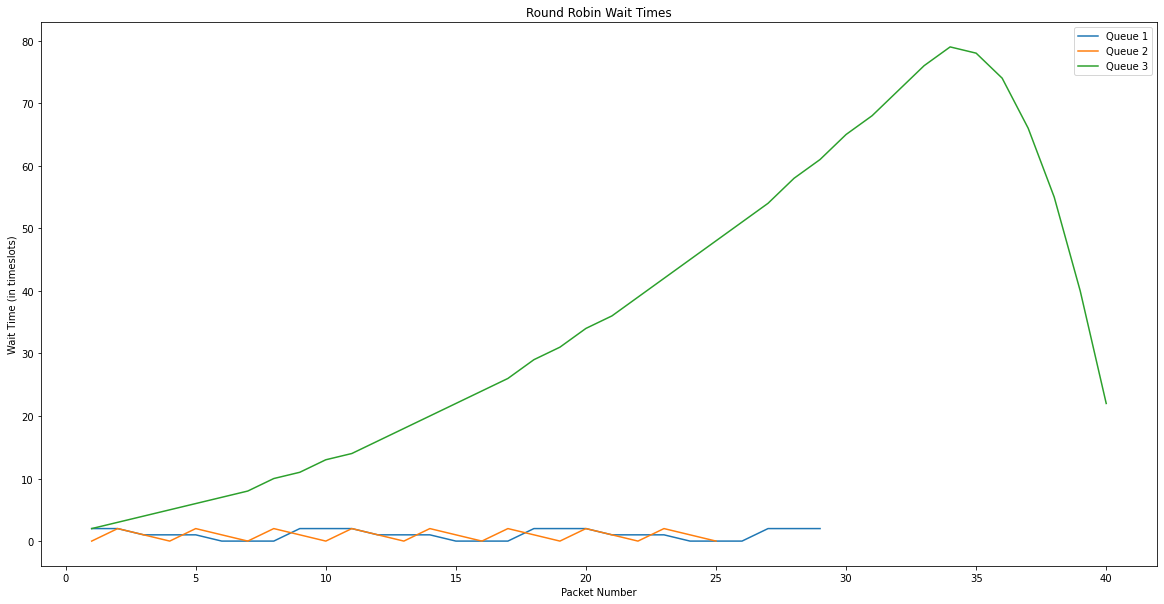

In [139]:
def round_robin(env):
    env.reset(1)
    done = False
    
    while not done:
        action = env.current_timeslot % 3
        new_state, reward, done, info = env.step(action)
    return env.queues_total_wait_times

rr_wait_times = round_robin(env)
for i, q in enumerate(rr_wait_times):
    print(q)

fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.25
for i, queue_wait_times in enumerate(rr_wait_times):
    data_y = queue_wait_times
    data_x = [*range(1, len(data_y)+1, 1)]

    ax.set_title('Round Robin Wait Times')
    ax.set_xlabel('Packet Number')
    ax.set_ylabel('Wait Time (in timeslots)')
    ax.plot(data_x, data_y, label='Queue {0}'.format(i+1))
ax.legend()
fig.show()
